In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import xgboost as xgb
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
color = sns.color_palette()
%matplotlib inline
matplotlib.style.use('ggplot')

# remove warnings
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display

from sklearn import preprocessing
from utils import data_util

In [2]:
print 'load datas...'
train, test = data_util.load_dataset()

y_train_all = train['y']
del train['ID']
del train['y']
id_test = test['ID']
del test['ID']

# Convert to numpy values
X_all = train.values
# Create a validation set, with last 20% of data
num_train = int(train.shape[0] * 0.8)
X_train_all = X_all
X_train = X_all[:num_train]
X_val = X_all[num_train:]
y_train = y_train_all[:num_train]
y_val = y_train_all[num_train:]
X_test = test
print "validate size:", 1.0 * X_val.shape[0] / X_train.shape[0]

print('X_train_all shape is', X_train_all.shape)
print('X_train shape is', X_train.shape)
print('y_train shape is', y_train.shape)
print('X_val shape is', X_val.shape)
print('y_val shape is', y_val.shape)
print('X_test shape is', X_test.shape)

df_columns = train.columns.values
dtrain_all = xgb.DMatrix(X_train_all, y_train_all, feature_names=df_columns)
dtrain = xgb.DMatrix(X_train, y_train, feature_names=df_columns)
dval = xgb.DMatrix(X_val, y_val, feature_names=df_columns)
dtest = xgb.DMatrix(X_test, feature_names=df_columns)

y_mean = np.mean(y_train)
xgb_params = {
    'n_trees': 500,
    'eta': 0.005,
    'max_depth': 4,
    'subsample': 0.95,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': y_mean,  # base prediction = mean(target)
    'silent': 1
}

# xgboost, cross-validation
cv_result = xgb.cv(xgb_params,
                   dtrain,
                   num_boost_round=500,  # increase to have better results (~700)
                   early_stopping_rounds=50,
                   verbose_eval=50,
                   show_stdv=False
                   )

num_boost_rounds = len(cv_result)
print 'num_boost_rounds =', num_boost_rounds
model = xgb.train(xgb_params, dtrain, num_boost_round=num_boost_rounds)
train_r2_score = r2_score(dtrain.get_label(), model.predict(dtrain))
val_r2_score = r2_score(dval.get_label(), model.predict(dval))
print 'train r2 score =', train_r2_score, ', validate r2 score =', val_r2_score

# train model
model = xgb.train(dict(xgb_params, base_score=np.mean(y_train_all)), dtrain_all, num_boost_round=num_boost_rounds)


load datas...
validate size: 0.250074250074
('X_train_all shape is', (4209, 426))
('X_train shape is', (3367, 426))
('y_train shape is', (3367,))
('X_val shape is', (842, 426))
('y_val shape is', (842,))
('X_test shape is', (4209, 426))
[0]	train-rmse:12.8896	test-rmse:12.8837
[50]	train-rmse:11.3458	test-rmse:11.4351
[100]	train-rmse:10.2739	test-rmse:10.4575
[150]	train-rmse:9.54204	test-rmse:9.81649
[200]	train-rmse:9.047	test-rmse:9.41137
[250]	train-rmse:8.71244	test-rmse:9.15948
[300]	train-rmse:8.46727	test-rmse:9.01345
[350]	train-rmse:8.24896	test-rmse:8.93258
[400]	train-rmse:8.06744	test-rmse:8.88676
[450]	train-rmse:7.91268	test-rmse:8.86436
[499]	train-rmse:7.76986	test-rmse:8.85162
num_boost_rounds = 500
train r2 score = 0.612386126966 , validate r2 score = 0.600934469325


In [3]:
def importance_XGB(clf):
    impdf = []
    for ft, score in clf.get_fscore().iteritems():
        impdf.append({'feature': ft, 'importance': score})
    impdf = pd.DataFrame(impdf)
    impdf = impdf.sort_values(by='importance', ascending=False).reset_index(drop=True)
    impdf['importance'] /= impdf['importance'].sum()
    return impdf

In [4]:
impdf = importance_XGB(model)

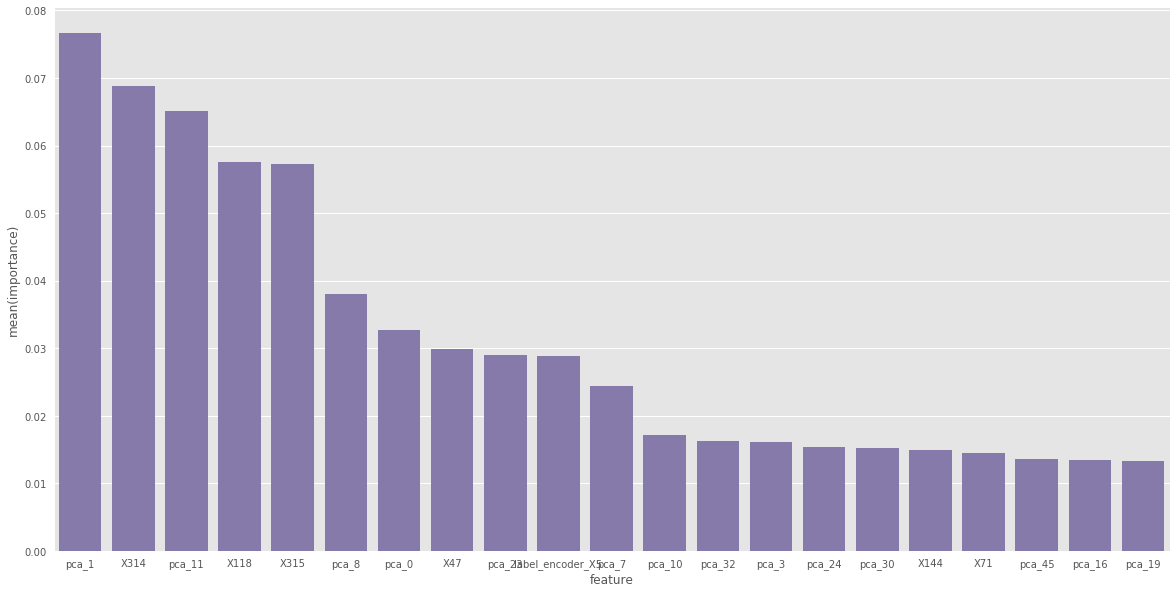

In [5]:
plt.figure(figsize=(20, 10))
sns.barplot(x='feature', y='importance', data=impdf.loc[:20, :], color=color[3])